### Train DNN

In [1]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
#from sklearn.model_selection import StratifiedKFold, KFold
#from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, TensorDataset, DataLoader
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


import torch.nn.functional as F
import sys
module_path = Path().resolve().parents[1] / "src" / "models"

# Append the directory to sys.path
sys.path.append(str(module_path))


from trainDNN import *
from explainDNN import *
from predictDNN import *

module_path = Path().resolve().parents[1] / "src" / "postprocessing"

# Append the directory to sys.path
sys.path.append(str(module_path))


from getModelPerformance import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Load features

In [2]:
feature_path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_CS_men_2_3_84_1"
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labels.npy"))
lats = np.load(Path(feature_path / "numpy_lat.npy"))
lons = np.load(Path(feature_path / "numpy_lon.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)


In [3]:
features.shape[1]

139

In [4]:
features

array([[1.13322494e+00, 3.52674256e+00, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 8.14808309e-01],
       [7.29792687e-01, 3.67310753e-01, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 1.25000000e+00],
       [2.31564436e+00, 5.28737645e-01, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 1.25000000e+00],
       ...,
       [1.05823756e+00, 4.44194299e-01, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 3.38988471e+00],
       [3.52029471e+00, 2.45295954e+00, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 1.27137017e+00],
       [2.55159641e+00, 5.67175186e-01, 9.99990000e+04, ...,
        0.00000000e+00, 0.00000000e+00, 1.25000000e+00]])

#### Define the neural network architecture

In [5]:
loss_fn = torch.nn.MSELoss()

In [6]:
class DNN(torch.nn.Module):
    def __init__(self, layer_width):
        super(DNN, self).__init__()

        self.do_prob = 0.2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(features.shape[1], layer_width[0]),
            torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], layer_width[1]),
            torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[2]),
            torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[3]),
            torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[4]),
            torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[5]),
            torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[6]),
            torch.nn.BatchNorm1d(layer_width[6]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),

        )

        self.decoder = torch.nn.Sequential(

            # torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[6], layer_width[5]),
            #torch.nn.BatchNorm1d(layer_width[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[5], layer_width[4]),
            #torch.nn.BatchNorm1d(layer_width[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[4], layer_width[3]),
            #torch.nn.BatchNorm1d(layer_width[3]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[3], layer_width[2]),
            #torch.nn.BatchNorm1d(layer_width[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[2], layer_width[1]),
            #torch.nn.BatchNorm1d(layer_width[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[1], layer_width[0]),
            #torch.nn.BatchNorm1d(layer_width[0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[0], features.shape[1])
        )

        self.supervised = torch.nn.Sequential(
            torch.nn.Linear(layer_width[6], layer_width[7]),
            torch.nn.BatchNorm1d(layer_width[7]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[7], layer_width[8]),
            torch.nn.BatchNorm1d(layer_width[8]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[8], layer_width[9]),
            torch.nn.BatchNorm1d(layer_width[9]),
            torch.nn.ReLU(),
            torch.nn.Dropout(self.do_prob),
            torch.nn.Linear(layer_width[9], 1),

        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        targets = self.supervised(encoded)
        #return decoded, targets
        return targets
        
def initialize_weights(m):

    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)



In [7]:

layer_widths = [512, 512, 512, 512, 512, 512, 512, 512, 512, 512]  # Define your desired layer widthsmodel = DNN(layer_widths)#DNN(input_dim, layer_widths)
model = DNN(layer_widths)#DNN(input_dim, layer_widths)
model.apply(initialize_weights)
model.double()


DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [8]:
model = DNN(layer_widths)
model = model.double()
model.apply(initialize_weights)

torch.manual_seed(42)

In [9]:
#time intensive operation(better save processed features and labels, after first run)
features, labels, lats, lons = preprocess_features_labels(features, labels, lats, lons, X_mean, X_std) 
np.save("preprocessed/features_CS_2_3_84_1", features)
np.save("preprocessed/labels_CS_2_3_84_1", labels)
np.save("preprocessed/lats_CS_2_3_84_1", lats)
np.save("preprocessed/lons_CS_2_3_84_1", lons)

Duplicate row with index [22927 45142] was in group 4 and was replaced with NaN values
Duplicate row with index [ 4324  4489  9751 25442 38937 40833] was in group 18 and was replaced with NaN values
Duplicate row with index [ 2366 16308 28844 42827 42902 43952 45960 46118 48658] was in group 33 and was replaced with NaN values
Duplicate row with index [10661 26027 37734 47844] was in group 73 and was replaced with NaN values
Duplicate row with index [29177 45105 54110 56071] was in group 90 and was replaced with NaN values
Duplicate row with index [4177 4800] was in group 102 and was replaced with NaN values
Duplicate row with index [27714 32379] was in group 145 and was replaced with NaN values
Duplicate row with index [22021 31349 33858 43889 45956 53940] was in group 170 and was replaced with NaN values
Duplicate row with index [  442 37280 47421] was in group 221 and was replaced with NaN values
Duplicate row with index [ 2213 10559 11753] was in group 226 and was replaced with NaN

In [9]:
features = np.load("preprocessed/features_CS_2_3_84_1.npy")
labels = np.load("preprocessed/labels_CS_2_3_84_1.npy")

In [10]:
features.shape

(13630, 139)

In [11]:
features = torch.tensor(features)
labels = torch.tensor(labels)

In [12]:
trainloader, testloader = create_train_test_loader(features, labels, batch_size = 200, test_size_ratio=1/7, shuffle=True)

Train data size
11683
Test data size
1947


In [13]:
"""
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
"""

'\nprint(f"Model structure: {model}\n\n")\n\nfor name, param in model.named_parameters():\n    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")\n'

In [14]:
# if there is a pretrained model, this can be used
"""
path = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_CS.pth"
state_dict = torch.load(path)
model.load_state_dict(state_dict)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else 
#print(physical_devices)
model.to(device)
model.double()
"""

'\npath = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_CS.pth"\nstate_dict = torch.load(path)\nmodel.load_state_dict(state_dict)\ndevice = torch.device(\'cuda:0\' if torch.cuda.is_available() else \'cpu\') #\'cuda:0\' if torch.cuda.is_available() else \n#print(physical_devices)\nmodel.to(device)\nmodel.double()\n'

In [15]:
# GPU intensive operation!!
num_epochs = 500
training_accuracy, training_losses, training_mae, learning_rate, evaluation_losses, evaluation_mae, true_labels, pred_labels =  train_model(model, loss_fn, trainloader, testloader, num_epochs = num_epochs)

epoch: 0 | Training Loss: 2.948 | MAE: 0.596 | LR: 0.0100000 |
epoch: 0 | Testing Loss: 0.614 | MAE: 0.357  |

epoch: 1 | Training Loss: 0.701 | MAE: 0.360 | LR: 0.0100000 |
epoch: 1 | Testing Loss: 0.494 | MAE: 0.298  |

epoch: 2 | Training Loss: 0.706 | MAE: 0.342 | LR: 0.0100000 |
epoch: 2 | Testing Loss: 0.375 | MAE: 0.276  |

epoch: 3 | Training Loss: 0.606 | MAE: 0.322 | LR: 0.0080000 |
epoch: 3 | Testing Loss: 0.448 | MAE: 0.290  |

epoch: 4 | Training Loss: 0.621 | MAE: 0.311 | LR: 0.0064000 |
epoch: 4 | Testing Loss: 0.399 | MAE: 0.284  |

epoch: 5 | Training Loss: 0.543 | MAE: 0.299 | LR: 0.0064000 |
epoch: 5 | Testing Loss: 0.440 | MAE: 0.274  |

epoch: 6 | Training Loss: 0.575 | MAE: 0.302 | LR: 0.0051200 |
epoch: 6 | Testing Loss: 0.358 | MAE: 0.242  |

epoch: 7 | Training Loss: 0.486 | MAE: 0.281 | LR: 0.0040960 |
epoch: 7 | Testing Loss: 0.325 | MAE: 0.231  |

epoch: 8 | Training Loss: 0.477 | MAE: 0.273 | LR: 0.0040960 |
epoch: 8 | Testing Loss: 0.367 | MAE: 0.269  |

e

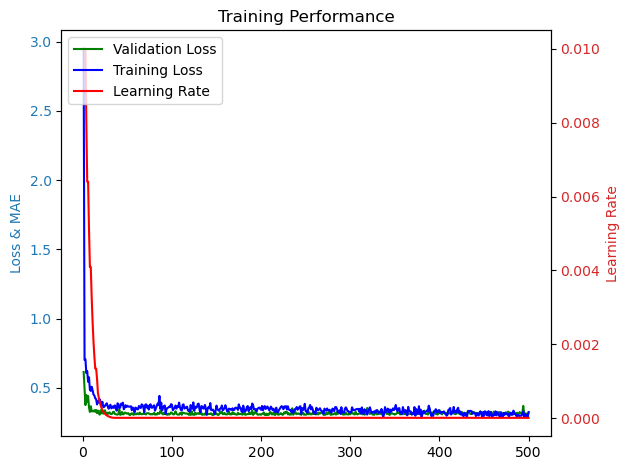

In [16]:
torch.manual_seed(42)
plot_model_performance(num_epochs, evaluation_losses, training_losses, learning_rate)

In [17]:
output_path = Path().resolve().parents[1] / "data" / "output" / "scatterplots_TOC" / "scatter_plot_TOC_noconstraint_supervised_CS_men_2_3_84_1.png"
output_path = str(output_path)
test_labels, test_targets = evaluate_model(model, testloader, output_path)

(1947,)
(1947,)
correlation coefficient:
0.8539833321774303
mae:
0.21717975449677063
mse:
0.3250440400442174
rmse:
0.5701263369150888


In [18]:
#lats = np.load("lats_CS.npy")
#lons = np.load("lons_CS.npy")
all_labels, all_targets =  evaluate_all_predictions(model, features, labels, output_path)


correlation coefficient:
0.9020039815922751
mae:
0.1948670149309725
mse:
0.26301216063956984
rmse:
0.5128471123439907


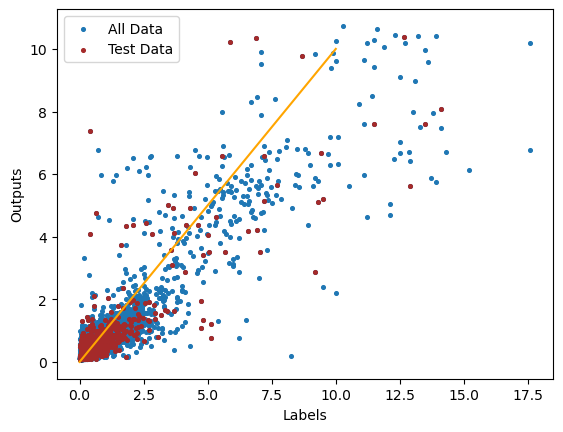

In [19]:
# Scatter plot with different colors for test labels and test targets
plt.scatter(all_labels, all_targets, label='All Data', s= 7)
plt.scatter(test_labels, test_targets, label='Test Data', color='brown', s=7)  # Add this line

line = np.linspace(0, 10, 100)

# Plot the reference line
plt.plot(line, line, 'orange')

# Set labels and title
plt.xlabel("Labels")
plt.ylabel("Outputs")

# Add legend
plt.legend()

In [20]:
#torch.save(model.state_dict(), path = Path().resolve().parents[1] / "models" / "supervisedmodel_TOC_noconstraint_CS_2_3_84_1.pth")

In [21]:
#"""
np.save("all_labels_NN_CS_2_3_84_1", all_labels)
np.save("all_predictions_NN_CS_2_3_84_1", all_targets)
np.save("test_labels_NN_CS_2_3_84_1", test_labels)
np.save("test_predictions_NN_CS_2_3_84_1", test_targets)
#"""

### Explain DNN using SHAP values (Find feature importance)

In [10]:

#should shuffle the indices again
features = np.load("preprocessed/features_CS.npy")
labels = np.load("preprocessed/labels_CS.npy")

import shap
import pandas as pd

# Convert the input features to a PyTorch tensor with the correct data type
features = torch.tensor(features, dtype=torch.float64)

if torch.cuda.is_available():
    features = features.cuda()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


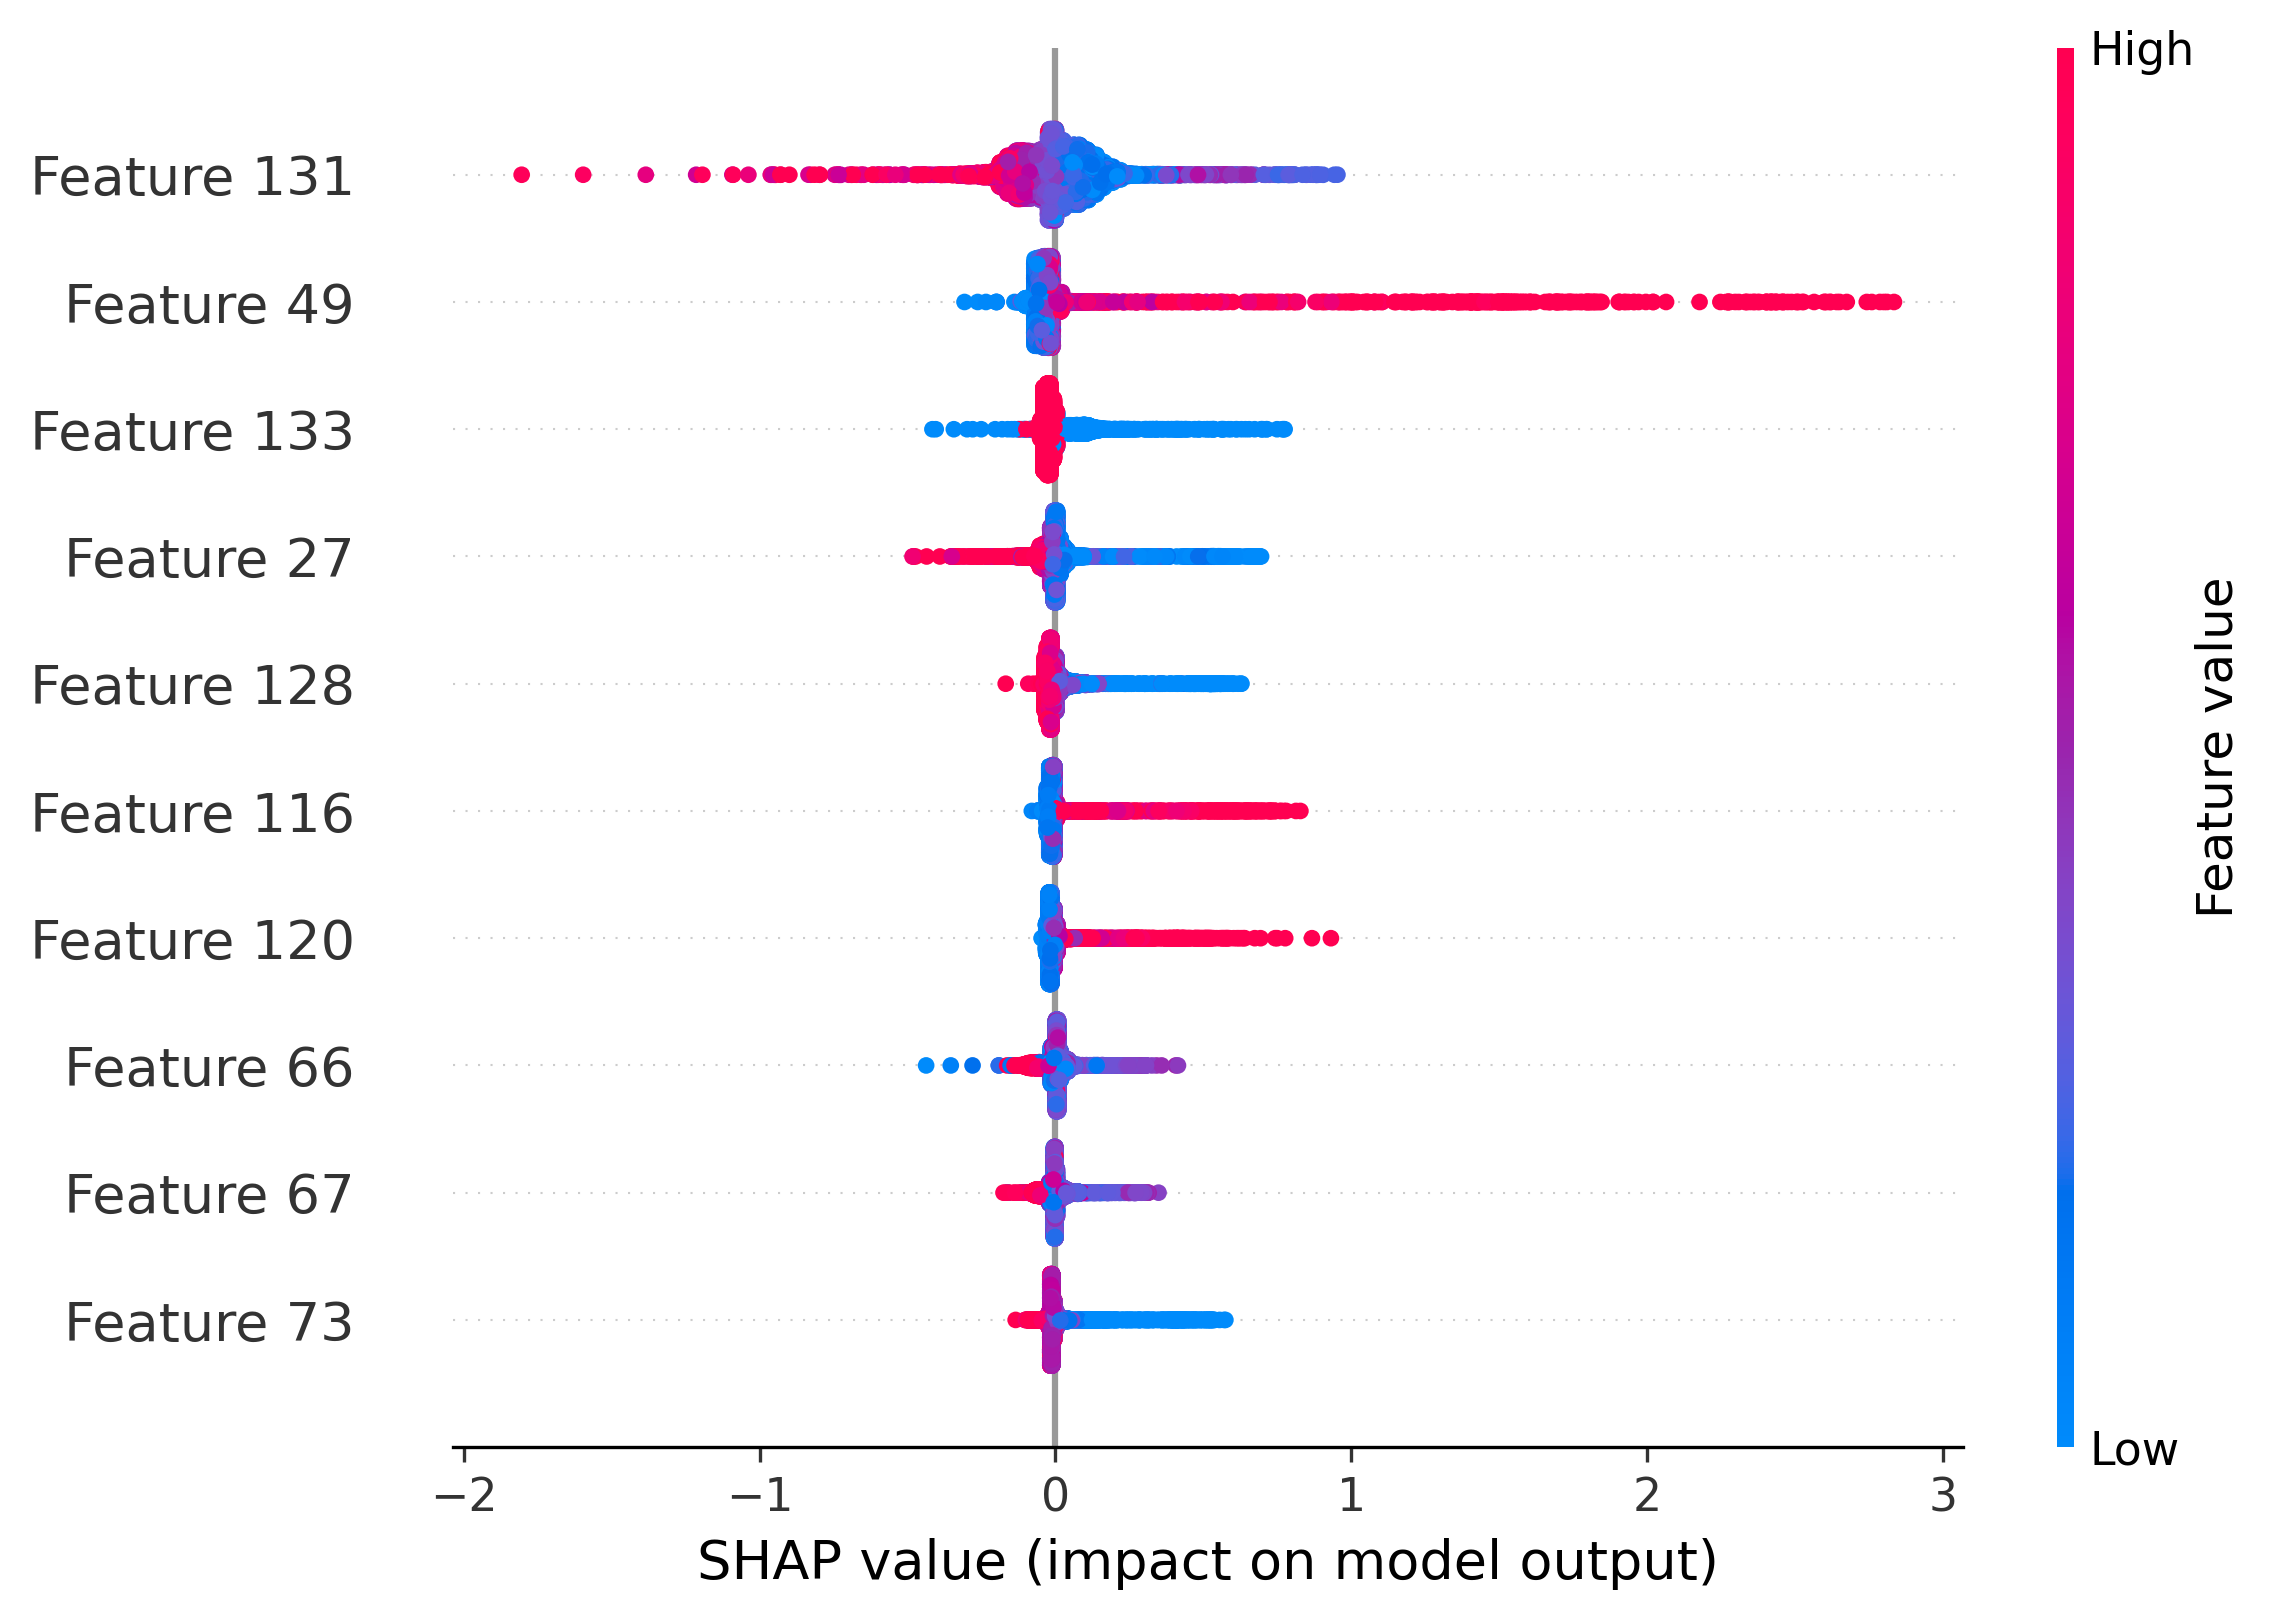

In [25]:
# GPU intensive operation!!!
explain_shap(model, features, feature_names=None, explainer_path='preprocessed/explainer_CS.pkl', shap_values_path='preprocessed/shap_values_CS.pkl', force_plot_index=0, summary_max_display=10)

#if the previous line has already been performed and the shap values are saved, only the following lines can be used.
with open('preprocessed/explainer_CS.pkl', 'rb') as explainer_file:
    explainer = pickle.load(explainer_file)

with open('preprocessed/shap_values_CS.pkl', 'rb') as shap_values_file:
    shap_values = pickle.load(shap_values_file)

### Predict using the trained DNN

In [10]:
import torch
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os
import gc
from os import walk  


feature_path = path = Path().resolve().parents[1] / "data" / "interim" / "inputfeatures" / "SedTOCFeaturesnoNAN_TOC_CS_men_2_3_84_1"
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)

dataset_path = Path().resolve().parents[1] / "data" / "interim" / "worldfeatures" / "WorldFeaturesAllnoNaN_SedTOC"

files = []

for (dirpath, dirnames, filenames) in walk(dataset_path):
    files.extend(filenames)
    break

files.sort()


features = np.load(Path(dataset_path / files[0]))
prediction_sum_save = Path().resolve().parents[1] / "data" / "interim" / "predictions" / "predictions_CS_2_3_84_1"

In [23]:


model.eval()
enable_dropout(model) #for mc dropout


np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #'cuda:0' if torch.cuda.is_available() else 
#print(physical_devices)
model.to(device)
model.double()


DNN(
  (encoder): Sequential(
    (0): Linear(in_features=139, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [24]:
features = np.load(Path(dataset_path / files[0]))

chunk_shape = [6,4320] #360 chunks


first_run = True
ii = 0

for count, file in enumerate(files):
    #if count > 2:
    #    break
    features = np.load(Path(dataset_path / file))
    features = np.divide((features - X_mean), X_std)

    features = torch.tensor(features)
    features = features.to(device)

    # Perform multiple forward passes with dropout
    num_samples = 100  # number of monte carlo forward passes: gives us the number of predictions or the size of the prediction ensemble
    predictions_sum = np.zeros((num_samples, chunk_shape[0], chunk_shape[1]))

    with torch.no_grad():
        for i in range(num_samples):
            predictions = model(features)
         
            # Store predictions for later averaging
            predictions_sum[i] = predictions.cpu().detach().numpy().reshape(chunk_shape)

    # Average predictions over all samples
    predictions_avg = np.mean(predictions_sum, axis=0)
    predictions_var = np.var(predictions_sum, axis=0)
    save_path = os.path.join(prediction_sum_save , f'predictions_sum_{ii}.npy')
    np.save(save_path, predictions_sum)
    #fit_params, failed_fits, failed_fit_details = fit_gaussian_to_predictions(predictions_sum)
    #print(failed_fits)

    if first_run:
        prediction_map2 = predictions_avg
        prediction_map2_var = predictions_var
        first_run = False
    else:
        prediction_map2 = np.append(prediction_map2, predictions_avg, axis=0)
        prediction_map2_var = np.append(prediction_map2_var, predictions_var, axis=0)

    ii += 1
    print("Prediction " + str(ii) + " done!")

    del features
    gc.collect()
    


Prediction 1 done!
Prediction 2 done!
Prediction 3 done!
Prediction 4 done!
Prediction 5 done!
Prediction 6 done!
Prediction 7 done!
Prediction 8 done!
Prediction 9 done!
Prediction 10 done!
Prediction 11 done!
Prediction 12 done!
Prediction 13 done!
Prediction 14 done!
Prediction 15 done!
Prediction 16 done!
Prediction 17 done!
Prediction 18 done!
Prediction 19 done!
Prediction 20 done!
Prediction 21 done!
Prediction 22 done!
Prediction 23 done!
Prediction 24 done!
Prediction 25 done!
Prediction 26 done!
Prediction 27 done!
Prediction 28 done!
Prediction 29 done!
Prediction 30 done!
Prediction 31 done!
Prediction 32 done!
Prediction 33 done!
Prediction 34 done!
Prediction 35 done!
Prediction 36 done!
Prediction 37 done!
Prediction 38 done!
Prediction 39 done!
Prediction 40 done!
Prediction 41 done!
Prediction 42 done!
Prediction 43 done!
Prediction 44 done!
Prediction 45 done!
Prediction 46 done!
Prediction 47 done!
Prediction 48 done!
Prediction 49 done!
Prediction 50 done!
Predictio

In [25]:
### GPU intensive operation!!
#prediction_map2, prediction_map2_var = perform_mc_dropout_prediction(model, dataset_path, prediction_sum_save, X_mean, X_std)

In [11]:
# We save the distributions or the monte carlo output for each chunk. Here we read all the distributions from different chunks and paste it together.
# Reading the distributions of all the chunks requires a lot of memory!!
# Requires high memory(RAM)(atleast 65 GB of RAM). Should probably be run on a CPU(prefereable a cluster) to get all the prediction distributions.
# UNCOMMENT IT TO PUT THE CHUNKS OF THE DISTRIBUTIONS TOGETHER
#"""
import os
import numpy as np

# Get a list of files in the directory and sort them
files_in_dir = sorted([f for f in os.listdir(prediction_sum_save) if f.endswith('.npy')], key=lambda x: int(x.split('_')[-1][:-4]))


failed_fits_all = []
i = 0
first_run = True

# Load and concatenate each predictions_sum array along the second axis
for file in files_in_dir:
    file_path = os.path.join(prediction_sum_save, file)
    predictions_sum = np.load(file_path)
    
    if first_run:
        prediction_map_dist = predictions_sum
        first_run = False
    else:
        # Concatenate along the second axis (axis=1)
        prediction_map_dist = np.concatenate((prediction_map_dist, predictions_sum), axis=1)
    i += 1
    print(i)
np.save(Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_dist_CS_2_3_84_1", prediction_map_dist)
#"""

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [27]:
land_file = path = Path().resolve().parents[1] / "data" / "raw" / "island_map.npy"
land_map = np.load(land_file)
land_map[np.isnan(land_map)] = 1


In [28]:
import matplotlib.colors as mcolors
prediction_map2 = np.rot90(np.rot90(np.fliplr(prediction_map2)))
#prediction_map2[land_map] = 0

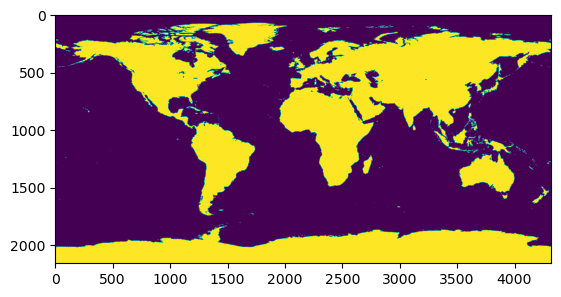

In [29]:
plt.imshow(land_map)

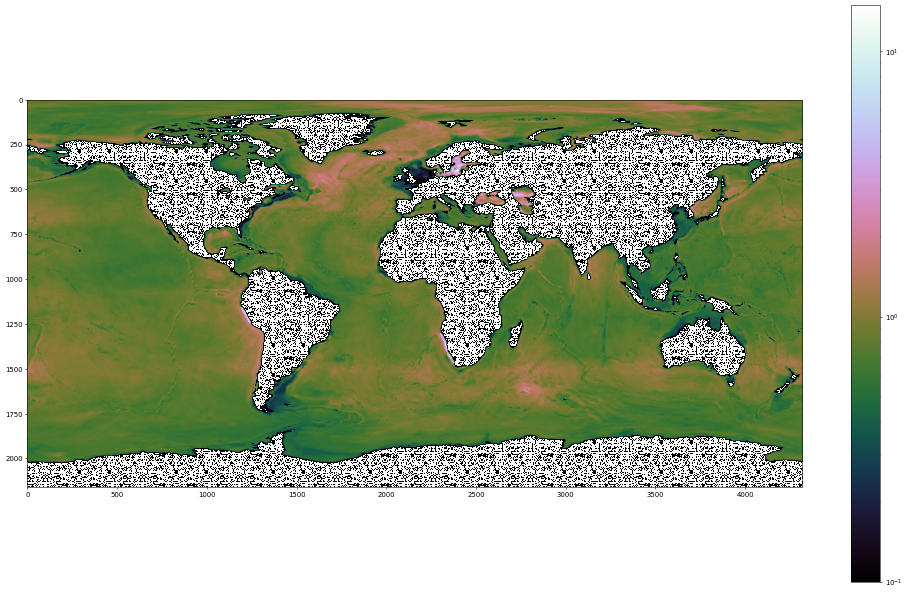

In [30]:
prediction_map2[land_map] = 0
plt.figure(figsize=[25, 15], dpi=50)
plt.imshow(prediction_map2, norm=mcolors.LogNorm(vmin=1e-1, vmax=15),cmap="cubehelix")
cbar = plt.colorbar()

In [31]:
np.save( Path().resolve().parents[1] / "data" / "output" / "predictionmaps_TOC" / "prediction_map_TOC_supervised_men_CS_2_3_84_1", prediction_map2)